# Pytorch Implementation of Gaussian VAE

In this notebook, we implemented a VAE where both the encoder and decoder model gaussian distributions. The model is trained on CelebA 64x64.

This implementation is in Pytorch.

For Tensorflow and JAX implementations, check the other notebooks.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

import torch

import torchsummary
import torchvision as tv
from torchvision import transforms, datasets
from torchvision.transforms import v2

from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

from torch.distributions.normal import Normal
import torch.nn.functional as F

import torch.nn as nn
from torch.nn import ReLU
from torch.optim.lr_scheduler import _LRScheduler

from time import time

2024-03-03 19:15:17.524262: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-03 19:15:17.552865: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 19:15:17.552919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 19:15:17.554447: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 19:15:17.560374: I tensorflow/core/platform/cpu_feature_guar

Selecting device (GPU or CPU)

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.cuda.set_device(device) 

## Run Hyperparams

Define the training params.

`WARMUP_STEPS` defines the number of training updates over which we do a linear learning rate warmup. We found that such a learning rate warmup is very useful for model stability in the early stages of training.

`ENCODER_CONV_UNITS` and `DECODER_CONV_UNITS` are lists of lists. The outer list is a list of layers. Each layer is defined as a list of `[in_channels, out_channels, kernel_size, stride, activation]`.

`ENCODER_DENSE_UNITS` and `DECODER_DENSE_UNITS` are lists of lists. The outer list is a list of layers. Each layer is defined as a list of `[in_channels, out_channels, activation]`.

In [3]:
# Data params
INPUT_SHAPE = (3, 64, 64)

# Training params
BATCH_SIZE = 32
TOTAL_TRAINING_STEPS = 200000
EVAL_EVERY_N_STEPS = 2000
VALIDATION_STEPS = 50

# Optimizer params
INITIAL_LEARNING_RATE = 1e-3
DECAY_STEPS = 50000
DECAY_RATE = 0.5
WARMUP_STEPS = 1000

# Model params
ENCODER_CONV_UNITS = [[3,128,(4,4),(1,1), ReLU],   
                      [128,128,(4,4),(2,2), ReLU],   
                      [128,256,(4,4),(2,2), ReLU], 
                      [256,256,(4,4),(2,2), ReLU], 
                      [256,256,(4,4),(1,1), ReLU]]  

ENCODER_DENSE_UNITS = [[256*8*8,256, ReLU], 
                       [256,256 * 2, None]]

DECODER_DENSE_UNITS = [[256,256, ReLU], 
                       [256,256 * 8 * 8, ReLU]]

DECODER_CONV_UNITS = [[256,256,(4,4),(1,1), ReLU],
                      [256,256,(4,4),(2,2), ReLU],
                      [256,256,(4,4),(2,2), ReLU],
                      [256,128,(4,4),(2,2), ReLU],
                      [128,3*2,(4,4),(1,1), None]]

## Data Processing

In [4]:
def create_filepaths():
    filenames = pd.read_csv('celeba-dataset/list_eval_partition.csv')

    train_filenames = filenames[filenames['partition'] == 0]['image_id'].values
    val_filenames = filenames[filenames['partition'] == 1]['image_id'].values

    path_to_files = 'celeba-dataset/img_align_celeba/img_align_celeba/'
    train_filepaths = path_to_files + train_filenames
    val_filepaths = path_to_files+val_filenames
    
    return train_filepaths, val_filepaths

In [5]:
train_filepaths, val_filepaths = create_filepaths()

In [6]:
class CreateDataset(Dataset):
    
    def __init__(self, imgs):
        self.imgs = imgs
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        image = self.imgs[index]
        X = self.transform(image)
        return X,X
        
    def transform(self, path):
        img = tv.io.read_image(path)   
        img = transforms.v2.functional.resized_crop(img, 40, 15, 148, 148, INPUT_SHAPE[1:], transforms.InterpolationMode.BILINEAR, True)/255.
        return img
        

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images[0].detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

In [8]:
train_dataset = CreateDataset(train_filepaths)
val_dataset = CreateDataset(val_filepaths)

In [9]:
train_dl = DataLoader(train_dataset, 32, shuffle=True, pin_memory=True, num_workers=2) #num_workers=3
val_dl = DataLoader(val_dataset, 32, shuffle=True, pin_memory=True, num_workers=2)

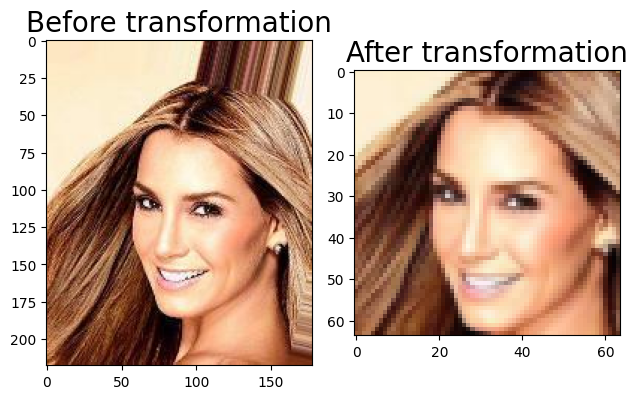

In [10]:
fig,axes = plt.subplots(1,2)
axes[0].imshow(tv.io.read_image(train_filepaths[0]).permute(1, 2, 0))
axes[0].set_title('Before transformation',fontsize=20)
axes[1].imshow(train_dataset.transform(train_filepaths[0]).permute(1,2,0))

axes[1].set_title('After transformation',fontsize=20)
plt.tight_layout()
plt.show()

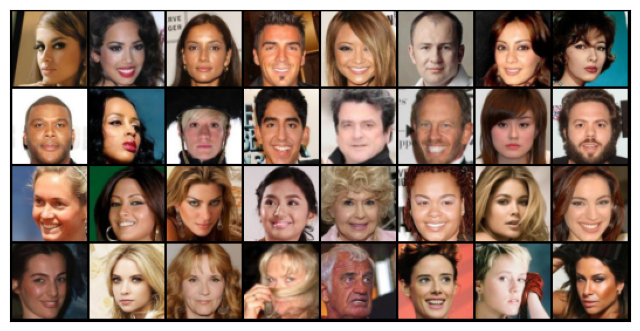

In [11]:
show_batch(train_dl, 32)

## Definining loss

For the Loss, we use the `Negative ELBO = -likelihood + KL_div`.

- `likelihood = decoder_dist.log_pdf(targets)`
- `KL_div = KL(posterior_dist || prior_dist)`
- The `posterior_dist` is the encoder distribution.
- For simplicity, we set the prior distribution to be a simple standard Gaussian `N(0, 1)`.

To help the model avoid a posterior collapse, we warmup the `KL_div` by linearly scaling it up over 10000 steps.

In [12]:
# Define the shape of z based on hparams
def z_shape():
    return [BATCH_SIZE, ENCODER_DENSE_UNITS[-1][1] // 2]

print(z_shape())

class NelboLoss(nn.Module):
    def __init__(self):
        super().__init__()
        zeros = torch.zeros(z_shape()).to(device)
        ones = torch.ones(z_shape()).to(device)
        self.prior = Normal(zeros,ones) 

    def __call__(self, dec_mean, dec_logstd,enc_mean,enc_logstd, targets,step):   
        likelihood = Normal(dec_mean, torch.exp(torch.maximum(dec_logstd, torch.tensor(-10.).to(device)))).log_prob(targets.to(device))   
        kl = torch.distributions.kl.kl_divergence(Normal(enc_mean,torch.exp(torch.maximum(enc_logstd,torch.tensor(-10.).to(device)))),self.prior) 
        denominator = torch.prod(torch.tensor(likelihood.shape,dtype=torch.float32))
        reconstuction_loss =-torch.sum(likelihood)/denominator
        kl_loss = (torch.sum(kl)/denominator)*torch.minimum(torch.tensor(step, dtype=torch.float32).to(device)*1e-4,torch.tensor(1.).to(device))
        neg_elbo = reconstuction_loss+kl_loss    # ()
        return neg_elbo, reconstuction_loss, kl_loss

[32, 256]


## Defining model

Utility class for general Conv2D with same padding

In [13]:
def pad_inputs(inputs, kernel_size, stride):
    assert kernel_size[1] == kernel_size[0]
    assert stride[1] == stride[0]
    
    padding = torch.tensor((kernel_size[0] - stride[0]) / 2).to(device)
    return F.pad(inputs.to(device), (torch.ceil(padding).int(), torch.floor(padding).int()) * 2)

class Conv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(Conv2D, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        

    def forward(self, inputs):
        x = pad_inputs(inputs, self.kernel_size, self.stride)
        x = self.conv(x)
        return x


In [14]:
# Define the unflatten shape used in the decoder based on hparams
def unflatten_shape():
    h, w = INPUT_SHAPE[1:]
    for stride in ENCODER_CONV_UNITS:
        h = h//stride[3][0]
        w = w//stride[3][1]   
    
    assert DECODER_DENSE_UNITS[-1][1] % (h*w) == 0
    unflatten_C = DECODER_DENSE_UNITS[-1][1] // (h*w)
    x = (BATCH_SIZE, unflatten_C, h, w)
    return x

print(unflatten_shape())

(32, 256, 8, 8)


In [15]:
class EncoderConvs(nn.Module):
    """
    Encoder Block.

    The Block is made of convolutions that downsample the image
    resolution until a certain point, after which we flatten the image
    and use a stack of Dense layers to get the posterior distribution q(z|x).
    """
    def __init__(self):     
        super(EncoderConvs, self).__init__()
        self.convs_list=[]        
        for in_channels, out_channels, kernel_size, stride, activation in ENCODER_CONV_UNITS:            
            self.convs_list.append(Conv2D(in_channels, out_channels, kernel_size, stride))
            if activation is not None:
                self.convs_list.append(activation())
        self.convs_list = nn.ModuleList(self.convs_list)

        self.dense_list = []
        for in_channels, out_channels, activation in ENCODER_DENSE_UNITS:
            self.dense_list.append(nn.Linear(in_channels, out_channels))
            if activation is not None:
                self.dense_list.append(activation())
        self.dense_list = nn.ModuleList(self.dense_list)
        
        
    def forward(self,x):
        for conv in self.convs_list:
            x = conv(x)

        x = x.view(x.shape[0], -1)

        for dense in self.dense_list:
            x = dense(x)
        return x  
    
class ResizeAndConv(nn.Module):
    """
    Resize-Conv Block.

    A simple Nearest-Neighbord upsampling + Conv block, used to upsample images instead of Deconv layers.
    This block is useful to avoid checkerboard artifacts: https://distill.pub/2016/deconv-checkerboard/
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ResizeAndConv,self).__init__()
        self.stride = (float(stride[0]), float(stride[1]))
        self.conv = Conv2D(in_channels, out_channels, kernel_size, (1,1))
        
        
    def forward(self, x):
        if self.stride != 1:
            x = F.interpolate(x, scale_factor=self.stride, mode='nearest')
        x = self.conv(x)
        return x

class DecoderConvs(nn.Module):
    """
    Decoder Block.

    The Decoder block starts off with Dense layers to process the sample z,
    followed by an unflatten (reshape) operation into an activation of shape (B, h, w, C).
    The activation is then upsampled back to the original image size using a stack
    of resize-conv blocks.
    """
    def __init__(self):
        super(DecoderConvs, self).__init__()
        self.convs_list=[]        
        for in_channels, out_channels, kernel_size, stride, activation in DECODER_CONV_UNITS:            
            self.convs_list.append(ResizeAndConv(in_channels, out_channels, kernel_size, stride))
            if activation is not None:
                self.convs_list.append(activation())
        self.convs_list = nn.ModuleList(self.convs_list)

        self.dense_list = []
        for in_channels, out_channels, activation in DECODER_DENSE_UNITS:
            self.dense_list.append(nn.Linear(in_channels, out_channels))
            if activation is not None:
                self.dense_list.append(activation())
        self.dense_list = nn.ModuleList(self.dense_list)

    def forward(self,x):
        for dense in self.dense_list:
            x = dense(x)

        x = x.view(unflatten_shape())
        
        for conv in self.convs_list:
            x = conv(x)
        return x   

class VAEModel(nn.Module):
    """
    VAE model.

    A simple Encoder-Decoder architecture where both Encoder and Decoder model multivariate
    gaussian distributions.
    """
    def __init__(self):       
        super(VAEModel, self).__init__()
        self.encoder_convs = EncoderConvs()
        self.decoder_convs = DecoderConvs()
        
           
    def forward(self,inputs):
        enc_mean, enc_logstd = self.encode(inputs)           # (B, z_C, 1, 1)

        # Reparametrization trick (allow backprop)
        epsilon = torch.randn(enc_mean.shape)
        epsilon = epsilon.to(device)                         # (B, z_C, 1, 1)
        z = epsilon*torch.exp(enc_logstd)+enc_mean           # (B, z_C, 1, 1)
        
        dec_mean, dec_logstd = self.decode(z)                # (B, 3, H, W)
        return enc_mean, enc_logstd, dec_mean, dec_logstd
    
    def encode(self,inputs):
        x = self.encoder_convs(inputs)   
        enc_mean, enc_logstd = torch.chunk(x,2,1)
        return enc_mean, enc_logstd
    
    def decode(self,z):
        x = self.decoder_convs(z)  
        dec_mean, dec_logstd = torch.chunk(x,2,1) 
        return dec_mean, dec_logstd
    
    def generate(self, z_temp=1., x_temp=1.):
        """
        Randomly sample z from the prior distribution N(0, 1) and generate the image x from z.

        z_temp: float, defines the temperature multiplier of the encoder stddev. 
            Smaller z_temp makes the generated samples less diverse and more generic
        x_temp: float, defines the temperature multiplier of the decoder stddev.
            Smaller x_temp makes the generated samples smoother, and loses small degree of information.
        """
        z = torch.randn(z_shape()).to(device)
        z = z * z_temp
        
        dec_mean, dec_logstd = self.decode(z)
        return Normal(dec_mean, torch.exp(dec_logstd) * x_temp).sample()


In [16]:
model = VAEModel()
model = model.to(device)
torchsummary.summary(model, (BATCH_SIZE, *INPUT_SHAPE), batch_dim=None, 
                     col_names=("input_size", "output_size", "num_params"))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─EncoderConvs: 1-1                      [32, 3, 64, 64]           [32, 512]                 --
|    └─ModuleList: 2                     []                        []                        --
|    |    └─Conv2D: 3-1                  [32, 3, 64, 64]           [32, 128, 64, 64]         6,272
|    |    └─ReLU: 3-2                    [32, 128, 64, 64]         [32, 128, 64, 64]         --
|    |    └─Conv2D: 3-3                  [32, 128, 64, 64]         [32, 128, 32, 32]         262,272
|    |    └─ReLU: 3-4                    [32, 128, 32, 32]         [32, 128, 32, 32]         --
|    |    └─Conv2D: 3-5                  [32, 128, 32, 32]         [32, 256, 16, 16]         524,544
|    |    └─ReLU: 3-6                    [32, 256, 16, 16]         [32, 256, 16, 16]         --
|    |    └─Conv2D: 3-7                  [32, 256, 16, 16]         [32, 256, 8, 8]           1,048,832
|    |    └─ReL

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─EncoderConvs: 1-1                      [32, 3, 64, 64]           [32, 512]                 --
|    └─ModuleList: 2                     []                        []                        --
|    |    └─Conv2D: 3-1                  [32, 3, 64, 64]           [32, 128, 64, 64]         6,272
|    |    └─ReLU: 3-2                    [32, 128, 64, 64]         [32, 128, 64, 64]         --
|    |    └─Conv2D: 3-3                  [32, 128, 64, 64]         [32, 128, 32, 32]         262,272
|    |    └─ReLU: 3-4                    [32, 128, 32, 32]         [32, 128, 32, 32]         --
|    |    └─Conv2D: 3-5                  [32, 128, 32, 32]         [32, 256, 16, 16]         524,544
|    |    └─ReLU: 3-6                    [32, 256, 16, 16]         [32, 256, 16, 16]         --
|    |    └─Conv2D: 3-7                  [32, 256, 16, 16]         [32, 256, 8, 8]           1,048,832
|    |    └─ReL

## utility functions for training

In [17]:
MODEL_NAME = 'vae_celeba64_dense256'
path = f'pytorch_checkpoints/{MODEL_NAME}'
os.makedirs('pytorch_checkpoints', exist_ok=True)

def save_checkpoint(step, model, optimizer):
    torch.save({
            'step': step,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_schedule_state_dict': lr_schedule.state_dict(),
            }, path)

def load_checkpoint():
    if os.path.exists(path):
        ckpt = torch.load(path)
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        lr_schedule.load_state_dict(ckpt['lr_schedule_state_dict'])
        step = ckpt['step']
        print(f'Loaded checkpoint for step {step} from {path}')
        
    else:
        step = 0
        print(f"Didn't find checkpoint in {path}")
    return step

Metrics book keeping and plotting utilities

In [18]:
def plot_samples(tdec_mean, tdec_logstd, ttargets, vdec_mean, vdec_logstd, vtargets):
    _, axes = plt.subplots(1,8,figsize=(8,4))
    axes[0].imshow(ttargets[0].permute(1,2,0))
    axes[1].imshow(Normal(tdec_mean[0].cpu(),torch.exp(tdec_logstd[0]).cpu()).sample().permute(1,2,0))
    axes[2].imshow(ttargets[1].permute(1,2,0))
    axes[3].imshow(Normal(tdec_mean[1].cpu(),torch.exp(tdec_logstd[1]).cpu()).sample().permute(1,2,0))
    axes[4].imshow(vtargets[0].permute(1,2,0))
    axes[5].imshow(Normal(vdec_mean[0].cpu(),torch.exp(vdec_logstd[0]).cpu()).sample().permute(1,2,0))
    axes[6].imshow(vtargets[1].permute(1,2,0))
    axes[7].imshow(Normal(vdec_mean[1].cpu(),torch.exp(vdec_logstd[1]).cpu()).sample().permute(1,2,0))
    plt.tight_layout(pad=-2.)
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show() 
    
# Updates dictionary that stores changes in loss values
def get_results(results, losses):
    for i,key in enumerate(results.keys()):
        results[key].append(losses[i])

Learning rate schedule utility

In [19]:
class WarmupExponentialDecay(_LRScheduler):
    def __init__(self, optimizer, decay_steps, decay_rate, warmup_steps=500,
                 last_epoch=-1, verbose=False):
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate

        super(WarmupExponentialDecay, self).__init__(optimizer=optimizer, last_epoch=last_epoch, verbose=verbose)

    def get_lr(self):
        if self.last_epoch <= self.warmup_steps:
            lrs = [base_lr * np.minimum(self.last_epoch / self.warmup_steps, 1.) for 
                   base_lr in self.base_lrs]
            
        else:
            lrs = [base_lr * self.decay_rate ** ((self.last_epoch - self.warmup_steps) / self.decay_steps)
                   for base_lr in self.base_lrs]
        return lrs

    def _get_closed_form_lr(self):
        if self.last_epoch <= self.warmup_steps:
            lrs = [base_lr * np.minimum(self.last_epoch / self.warmup_steps, 1.) for 
                   base_lr in self.base_lrs]
            
        else:
            lrs = [base_lr * self.decay_rate ** ((self.last_epoch - self.warmup_steps) / self.decay_steps)
                   for base_lr in self.base_lrs]
        return lrs

Training loop utilities

In [20]:
def trainval_step(inputs, targets, steps, training=True):
    """
    Train/Val step based on the training argument.
    """
    if training:
        model.train()
        optimizer.zero_grad()
        enc_mean, enc_logstd, dec_mean, dec_logstd = model(inputs)
        loss_value, reconstruction_loss, kl_loss = loss(dec_mean, dec_logstd, enc_mean, enc_logstd, targets, steps)
        with torch.no_grad():
            loss_value.backward()
            optimizer.step()
            lr_schedule.step()
        return loss_value.item(), reconstruction_loss.item(), kl_loss.item()           

    else:
        model.eval()
        with torch.no_grad():
            enc_mean, enc_logstd, dec_mean, dec_logstd = model(inputs)
            loss_value, reconstruction_loss, kl_loss = loss(dec_mean, dec_logstd, enc_mean, enc_logstd, targets, steps)
            return loss_value.item(), reconstruction_loss.item(), kl_loss.item(), dec_mean, dec_logstd
        
def validate(dataset, steps):
    """
    Validation loop. 
    """
    avarage_loss = 0.
    avarage_rec_loss = 0.
    avarage_kl_loss = 0.
   
    for val_step,(inputs, targets) in zip(range(VALIDATION_STEPS), dataset):
        loss_value,reconstuction_loss, kl_loss,dec_mean, dec_logstd = trainval_step(inputs, targets, torch.tensor(steps,dtype=torch.float32), training=False) 
        avarage_loss += loss_value
        avarage_rec_loss += reconstuction_loss
        avarage_kl_loss += kl_loss
           
    avarage_loss /= (val_step + 1)
    avarage_rec_loss /= (val_step + 1)
    avarage_kl_loss /= (val_step + 1)   
    return avarage_loss,avarage_rec_loss,avarage_kl_loss, dec_mean[:2], dec_logstd[:2], targets[:2]

def validate_and_plot(train_dl,val_dl,steps):
    """
    Validation function for both train and val data + metrics and artifacts logging.
    """
    avarage_train_loss,avarage_train_rec_loss,avarage_train_kl_loss,tdec_mean, tdec_logstd,ttargets= validate(train_dl, steps)    
    avarage_val_loss,avarage_val_rec_loss,avarage_val_kl_loss,vdec_mean, vdec_logstd, vtargets = validate(val_dl, steps)
    
    print(f"\nsteps {steps}/{TOTAL_TRAINING_STEPS}  train_loss:  nelbo_{avarage_train_loss:.4f}  rec_{avarage_train_rec_loss:.4f} "  
          f"kl_{avarage_train_kl_loss:.4f}      val_loss:  nelbo_{avarage_val_loss:.4f} "  
          f"rec_{avarage_val_rec_loss:.4f}  kl_{avarage_val_kl_loss:.4f}")
    plot_samples(tdec_mean, tdec_logstd, ttargets, vdec_mean, vdec_logstd, vtargets)  
    print('')
    return avarage_train_loss,avarage_train_rec_loss,avarage_train_kl_loss,avarage_val_loss,avarage_val_rec_loss,avarage_val_kl_loss

def train(train_dl, val_dl, results):
    """
    Training loop
    """
    # Restore checkpoint
    initial_step = load_checkpoint()
    
    pbar = tf.keras.utils.Progbar(EVAL_EVERY_N_STEPS, stateful_metrics=['nelbo','rec','kl'])

    for step, (train_inputs, train_targets) in zip(range(initial_step, TOTAL_TRAINING_STEPS+1),train_dl):
        loss_value, reconstuction_loss, kl_loss = trainval_step(train_inputs.to(device), train_targets.to(device), torch.tensor(step), training=True) 
        pbar.update(step % EVAL_EVERY_N_STEPS, [('nelbo', loss_value),('rec', reconstuction_loss),('kl', kl_loss)])
        
        if step % EVAL_EVERY_N_STEPS == 0:
            losses = validate_and_plot(train_dl, val_dl, step)
            # update the results dict with latest metrics
            get_results(results, losses)   

            # Save model checkpoint
            save_checkpoint(step, model, optimizer)
            print(f'SAVED CHECKPOINT FOR STEP {step}..')

## Model training

In [21]:
loss = NelboLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=INITIAL_LEARNING_RATE)
lr_schedule = WarmupExponentialDecay(optimizer, decay_steps=DECAY_STEPS, 
                                   decay_rate=DECAY_RATE, warmup_steps=WARMUP_STEPS)


/home/rayhane/anaconda3/envs/sussy_speech_separation/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Didn't find checkpoint in pytorch_checkpoints/vae_celeba64_dense256


/tmp/ipykernel_597728/2138719222.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kl_loss = (torch.sum(kl)/denominator)*torch.minimum(torch.tensor(step, dtype=torch.float32).to(device)*1e-4,torch.tensor(1.).to(device))


   0/2000 [..............................] - ETA: 0s - nelbo: 1.0729 - rec: 1.0729 - kl: 0.0000e+00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



steps 0/200000  train_loss:  nelbo_1.0543  rec_1.0543kl_0.0000      val_loss:  nelbo_1.0566rec_1.0566  kl_0.0000


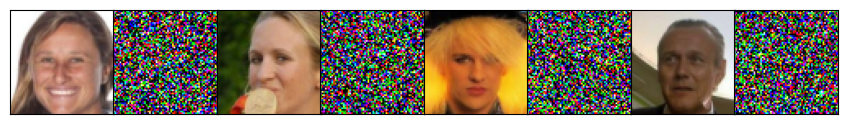


SAVED CHECKPOINT FOR STEP 0..
   0/2000 [..............................] - ETA: 0s - nelbo: -0.8960 - rec: -0.9081 - kl: 0.0122

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



steps 2000/200000  train_loss:  nelbo_-0.8132  rec_-0.8259kl_0.0127      val_loss:  nelbo_-0.8028rec_-0.8151  kl_0.0123


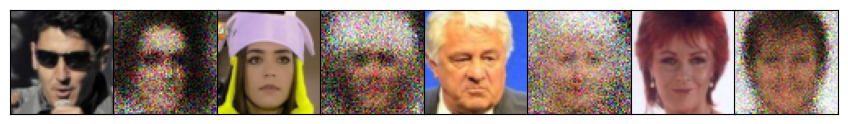


SAVED CHECKPOINT FOR STEP 2000..
  60/2000 [..............................] - ETA: 2:57 - nelbo: -0.7465 - rec: -0.7589 - kl: 0.0124

KeyboardInterrupt: 

In [22]:
results = {'nelbo':[],'rec':[],'kl':[],'val_nelbo':[],'val_rec':[],'val_kl':[]}
start_time=time()
train(train_dl,val_dl, results)
end_time=time()
print(f'Total time for {TOTAL_TRAINING_STEPS} is {end_time-start_time:.2f}s')

Plot the loss curves

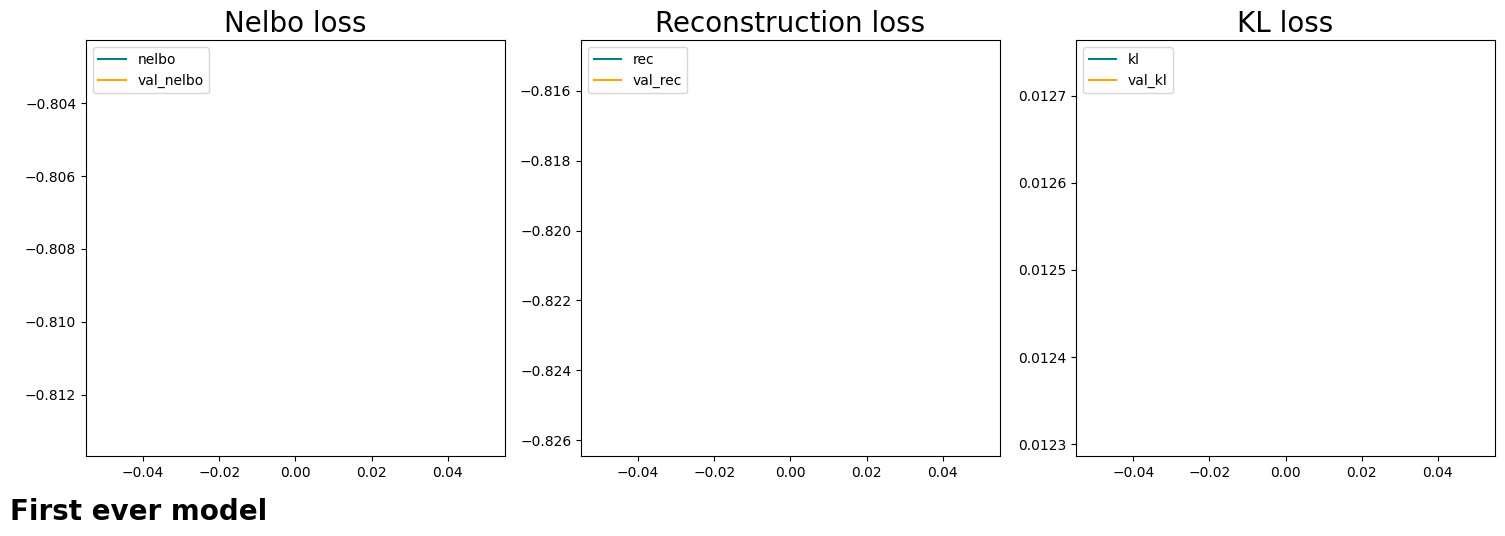

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(results['nelbo'][1:], color='teal', label='nelbo')
axes[0].plot(results['val_nelbo'][1:], color='orange', label='val_nelbo')
axes[0].set_title('Nelbo loss', fontsize=20)
axes[0].legend(loc="upper left")

axes[1].plot(results['rec'][1:], color='teal', label='rec')
axes[1].plot(results['val_rec'][1:], color='orange', label='val_rec')
axes[1].set_title('Reconstruction loss', fontsize=20)
axes[1].legend(loc="upper left")

axes[2].plot(results['kl'][1:], color='teal', label='kl')
axes[2].plot(results['val_kl'][1:], color='orange', label='val_kl')
axes[2].set_title('KL loss', fontsize=20)
axes[2].legend(loc="upper left")

plt.tight_layout()
fig.text(0., -0.05, 'First ever model', fontweight=900,fontsize=20)
plt.savefig('First_model.png')
plt.show()

## Model Generation

In this section, we generate new images from the prior distribution

In [24]:
# choose the model to generate from
MODEL_NAME = 'vae_celeba64_dense256'
path = f'pytorch_checkpoints/{MODEL_NAME}'

model = VAEModel()
model = model.to(device)
optimizer = torch.optim.Adamax(model.parameters(), lr=INITIAL_LEARNING_RATE)
lr_schedule = WarmupExponentialDecay(optimizer, decay_steps=DECAY_STEPS, 
                                   decay_rate=DECAY_RATE, warmup_steps=WARMUP_STEPS)
    
_ = load_checkpoint()

Loaded checkpoint for step 2000 from pytorch_checkpoints/vae_celeba64_dense256


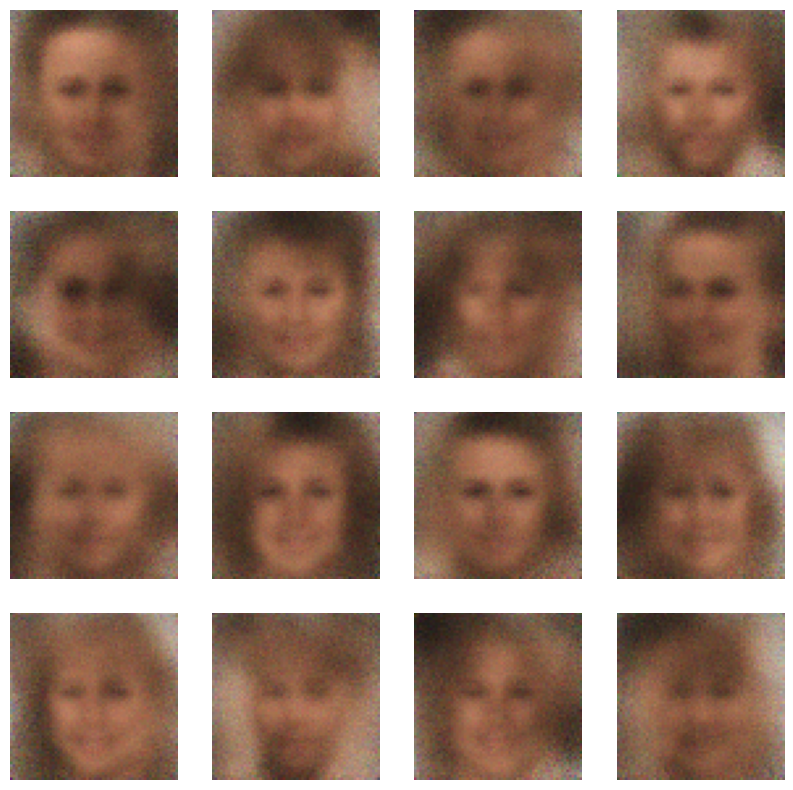

In [25]:
# Pick encoder distribution temperature (z_temp) and decoder distribution temperature (x_temp)
# Generate from the prior
pictures = model.generate(z_temp=1., x_temp=0.3).cpu()

# Plot grid of generated pictures
fig, axes32 = plt.subplots(4,4, figsize=(10,10))
for i, axes8 in enumerate(axes32):
    for j, ax in enumerate(axes8):
        index = i * axes32.shape[1] + j
        ax.imshow(pictures[index].permute(1,2,0))
        ax.axis('off')
plt.show()